## This Notebook will give me 10 exoplanets (not BEBs) and 10 noisy LCs

### Imports

In [1]:
################################
# Scientific imports
################################
import gc
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, statistics
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange
from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (16,4)
sb.set()

### Functions

In [154]:
#################################

def GetTICFromPos(arr, pos):
    # MUST BE NUMPY ARRAY
    # MUST BE OF FORM [[TIC, POS]]
    return(arr[np.where(arr[:, 0] == pos)[0][0]][1])

#################################

def GetPosFromTIC(arr, TIC):
    # MUST BE NUMPY ARRAY
    # MUST BE OF FORM [[TIC, POS]]
    TIC = TIC.zfill(10)
    return(int(arr[np.where(arr[:, 1] == TIC)[0][0]][0]))

#################################

def GetFName(arr, TIC_or_POS, verbose=False):
    # MUST BE NUMPY ARRAY
    # MUST BE OF FORM [[TIC, POS]]
    
    if len(TIC_or_POS) < 6:
        # POS
        if verbose:
            print("Detected a position!")
        return(arr[np.where(arr[:, 0] == TIC_or_POS)[0][0]][2])
    else:
        #TIC
        if verbose:
            print("Detected a TIC!")
        TIC_or_POS = TIC_or_POS.zfill(10)
        return(arr[np.where(arr[:, 1] == TIC_or_POS)[0][0]][2])

#################################

def MAKE_REF_LIST_OLD(l, arr):
    helper_arr = []

    for i in l:
        fname = [x for x in arr if i in x][0]
        w = np.where(arr == fname)[0][0]
        helper_arr.append([int(w),i,fname])
    return (np.array(helper_arr))

#################################

def MAKE_REF_LIST(l, arr):
    helper_arr = []

    for i in l:
        fname = [x for x in arr if i in x][0]
        w = np.where(arr == fname)[0][0]
        helper_arr.append([int(w),str(i).zfill(10),fname])
    return (np.array(helper_arr))

#################################

def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']
        tess_bjds     = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"
    xlab = "Transit time (days)"

    #ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)
    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)

#################################

def MakePictures(inArr, helper_arr, loopnum = 0, save=True, lims=None, name=None):
    fig = plt.figure(figsize=(16,20))

    # BEGIN LOOP
    
    #for i in range(numplots):
    for n,i in enumerate(inArr):
        
        # Get the fitsarr number
        fnum = GetPosFromTIC(helper_arr, i)
        
        # Get variables
        x,y,f,o,s,ylab,xlab = DrawLC(fnum)
        x[:] = [n - 1310 for n in x]
        
        # Make subplots
        plt.subplot(len(inArr), 1, n+1)
        plt.plot(x, y, '.', markersize=0.75)
        
        # Sort out limits
        if lims is not None:
            if lims[n] is not None:
                print(f"lims[{n}] = {lims[n]}")
                plt.ylim(lims[n])
        else:
            print(f"lims is empty!")

        # Print plot title
        plt.title(f"TOI № {o[4:]} from the TESS Input Catalog", fontsize=22)
        
        # Set tick font size
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        
        #print(f"TICKS = {plt.xticks()}")
        #plt.xticks(np.linspace(0,30,31,True))

    fig.add_subplot(111, frameon=False)

    plt.xticks([])
    plt.yticks([])

    plt.ylabel(ylab, fontsize=26, labelpad=100)
    plt.xlabel(xlab, fontsize=26, labelpad=50)
    
    plt.tight_layout()
    
    if name is None:
        name = "ExoExmplesNEW"
    
    savename = f"img/{name}_0{loopnum+1}.png"
    print(f"Savename = {savename}")
    if save:
        
        plt.savefig(f"img/{name}_0{loopnum+1}.png")
        print(f"SAVING AS {savename}...")
    else:
        print("NOT SAVING!")

#################################

def GenerateLists(obj = "all"):
    
    # Make Lists
    loc = "./SIM_DATA/unpacked/"

    with open(loc+"jake_PLIST") as f:
        p_list = [int(x) for x in f.read().splitlines()]

    with open(loc+"jake_EBLIST") as f:
        eb_list = [int(x) for x in f.read().splitlines()]

    with open(loc+"jake_BEBLIST") as f:
        beb_list = [int(x) for x in f.read().splitlines()]

    with open(loc+"jake_SLIST") as f:
        s_list = [int(x) for x in f.read().splitlines()]

    # Make empty lists
    uniq_p_list = []
    uniq_s_list = []
    uniq_eb_list = []
    uniq_beb_list = []

    print(f"OBJ = {obj}")
    
    if obj == "all":
        
        for i in p_list:
            if p_list.count(i) == 1:
                uniq_p_list.append(str(i).zfill(10))
    
        for i in s_list:
            if s_list.count(i) == 1:
                uniq_s_list.append(str(i).zfill(10))
    
        for i in eb_list:
            if eb_list.count(i) == 1:
                uniq_eb_list.append(str(i).zfill(10))
    
        for i in beb_list:
            if beb_list.count(i) == 1:
                uniq_beb_list.append(str(i).zfill(10))
        
        return (uniq_p_list, uniq_eb_list, uniq_beb_list, uniq_s_list)
    
    else:
        
        # Data Validation
        ary = ["p", "s", "eb", "beb"]
        if obj not in ary:
            print(f"NEEDS TO BE EITHER:\n{[i for i in ary]}")
            return
        
        # Actual loop
        L = f"{obj}_list"
        lst = eval(L)
        uL = f"uniq_{obj}_list"
        ulst = eval(uL)
        print(f"List type: {L}")
        #print(lst[0])
        #print(uL)

        for i in lst:                
            if lst.count(i) == 1:
                #print("adding to {ulst}")
                ulst.append(str(i).zfill(10))
        
        #retArr = eval(f"{uL}")
        print(f"RETURNING TO: {uL}")
        return(eval(uL))

#################################

### Initialisers

In [70]:
#################################
# NumPy loads
idlist  = np.load("idlist.npy")
fitsarr = np.load("fitslist.npy")

# Make all lists
P, EB, BEB, S = GenerateLists()

# Helper Array
helper_arr = MAKE_REF_LIST(P, fitsarr)
star_helper_arr = MAKE_REF_LIST(S, fitsarr)

# Remove all BEBs from planet list to make SUPER PLANET LIST
final_P = list(set(P) - set(BEB))
final_S = list(set(S) - set(P) - set(BEB) - set(EB))
#################################

OBJ = all


In [71]:
len(P), len(final_P), len(final_S), P[0], GetPosFromTIC(helper_arr, P[0])

(1115, 1051, 7146, '0006400274', 5002)

In [77]:
onlyplanets = list(set(final_P) - set(S))
onlystars = list(set(S) - set(P))

len(final_P), len(onlyplanets), len(S), len(onlystars)

(1051, 497, 8624, 8039)

In [85]:
# Putting the exoplanet light curve from "20220505 - all needed graphs" at the top of the list
newtmp = onlyplanets.copy()
newtmp.remove('0280726888')
newtmp = ['0280726888'] + newtmp
newtmp[:5]

['0280726888', '0453079202', '0149539552', '0453080267', '0167718729']

In [114]:
'0168885025' in onlystars

False

lims[0] = [59400, 60000]
lims[1] = [66300, 67200]
lims[2] = [127500, 129500]
lims[3] = [70600, 72000]
lims[4] = [753000, 758000]
Savename = img/ExoExamples_02.png
SAVING AS img/ExoExamples_02.png...


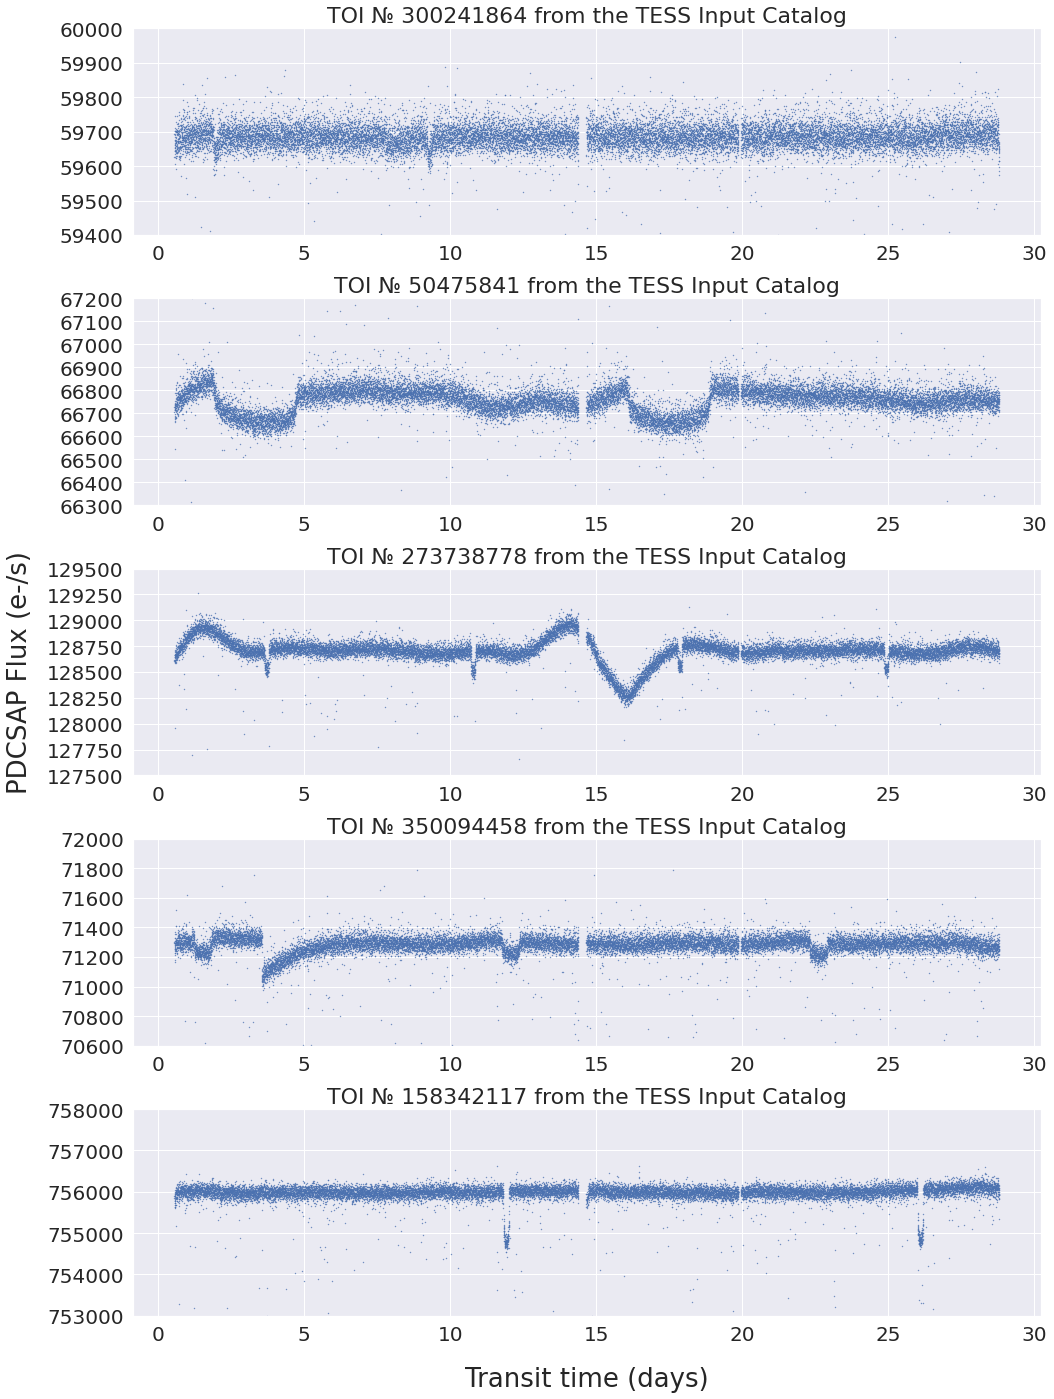

In [159]:
numPics = 5

y_lims = [None, None, None, None, None]
#y_lims = [[212000, 213000], [10650, 10950], [3200,3500], [60650, 61300], [300, 460]] # PLANET LIST 1
y_lims = [[59400, 60000], [66300, 67200], [127500, 129500], [70600, 72000], [753000, 758000]] # PLANET LIST 2

svnm = "ExoExamples"
#svnm = None

N = 0
sv = True

inArr = onlyplanets
inArr = onlystars
#inArr = ['0140658484', '0343837181', '0168885025', '0129480666', '0407621011'] # STAR LIST 1
#inArr = ['0280726888', '0271810970', '0300379556', '0261264993', '0372908431'] # PLANET LIST 1
inArr = ['0300241864', '0050475841', '0273738778', '0350094458', '0158342117'] # PLANET LIST 2

HA = helper_arr
#HA = star_helper_arr

#MakePictures(random.sample(newtmp, numPics))
MakePictures(inArr[(N)*numPics:(N+1)*numPics], HA, loopnum=N, lims=y_lims, save=sv, name=svnm)

In [39]:
#np.where(star_helper_arr[:, 1] == onlystars[0])[0][0]
np.where(star_helper_arr[:, 1] == onlystars[0])[0]

array([5896])

In [131]:
GetPosFromTIC(helper_arr,'0300379556')

12627

In [128]:
x,y,f,o,s,yl,xl = DrawLC(GetPosFromTIC(helper_arr,'0300379556'))

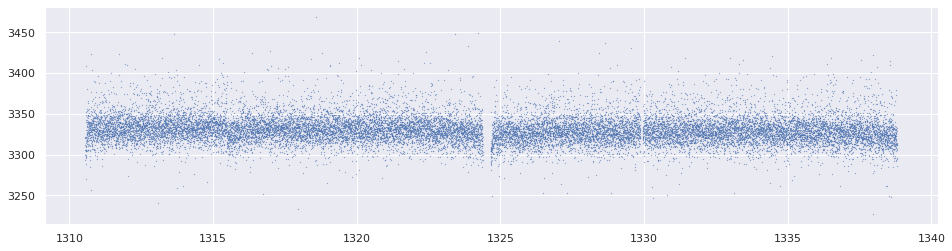

In [130]:
plt.plot(x,y,'.', markersize=0.5)

In [145]:
[-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]

[-5.0, 0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0]

In [151]:
np.linspace(0,30,31,True)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30.])